In [132]:
#Data Analysis
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import pandas as pd 
import time
import glob
from collections import defaultdict,Counter
from nltk.stem.porter import *
import string
import numpy as np
from nltk.corpus import stopwords
import math
from matplotlib import pyplot as plt

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score


from collections import defaultdict
import math
import pandas as pd 
import time
import glob
from collections import defaultdict,Counter
from nltk.stem.porter import *
import string
import numpy as np
from nltk.corpus import stopwords
import math
from matplotlib import pyplot as plt

#extract useful information
def loadData(path):
    '''
    read data from several csv files
    param path(str): the directory of data files
    return: dataframe
    '''
    files = glob.glob(path+'/*.csv')
    df=pd.concat([pd.read_csv(f) for f in files])
    return df

def form_sentence(tweet):
    tweet_blob = TextBlob(str(tweet))
    return ' '.join(tweet_blob.words)

#text clean
def no_number_alpha(tweet):
    tweet_list = tweet.split()
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word.lower() for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess
#word normalization
def normalization(tweet):
    tweet=form_sentence(tweet)
    tweet_list=no_number_alpha(tweet)
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet_list:
        normalized_text = lem.lemmatize(word,'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet

def load_sentiment_dict(path='/Users/zmhlala/UCSD_Wellness/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'):
    '''
    load lexicon file into a word:list of sentiments dictionary
    '''
    word_senti=open(path,'r')
    word_sentiment_dict=defaultdict(list)
    sentiment_set=set()
    for w_sent in word_senti.readlines():
        w_sent=w_sent.strip('\n').split('\t')
        if len(w_sent)<3:
            print(w_sent)
            continue
        word=w_sent[0]
        sentiment=w_sent[1]
        if w_sent[2]=='1':
            word_sentiment_dict[word].append(sentiment)
        sentiment_set.add(sentiment)
    word_senti.close()
    return word_sentiment_dict

def sentiment_category(content_list):
    
    sentiment_score=defaultdict(int)

    for w in content_list:
        if w in word_senti:
            sentiments=word_senti[w]
            for senti in sentiments:
                if senti not in ['positive','negative']:
                    sentiment_score[senti]+=1
    
    score_senti=[(score,senti) for senti,score in sentiment_score.items()]
    score_senti.sort()
    if score_senti:
        return score_senti[0][1]
    

def two_class_sentiment_category(content_list):
    
    sentiment_score=defaultdict(int)
    for w in content_list:
        if w in word_senti:
            sentiments=word_senti[w]
            for senti in sentiments:
                if senti in ['positive','negative']:
                    sentiment_score[senti]+=1
    
    score_senti=[(score,senti) for senti,score in sentiment_score.items()]
    score_senti.sort()
    if score_senti:
        return score_senti[0][1]
    
def hour_plot(confessions):
    hour_distri=confessions.groupby('hour')['content'].count().sort_index()
    fig,ax=plt.subplots()
    ax.plot(hour_distri.index,hour_distri.values)
    ax.set(xlabel='hour',ylabel='# of confessions')
    X=hour_distri.index
    simple_X=[X[i] for i in range(len(X)) if i%2==0]
    ax.xaxis.set_ticks(simple_X)
    ax.grid()
    fig.savefig('hour.png')
    plt.show()
    
def weekday_plot(confessions):
    weekday_distri=confessions.groupby('weekday')['content'].count().sort_index()
    fig, ax = plt.subplots()
    ax.plot(list(weekday_distri.index),weekday_distri.values)
    ax.set(xlabel='weekday', ylabel='# of confessions')
    ax.grid()
    fig.savefig("weekday.png")
    plt.show()

def week_plot(confessions):
    fig,ax=plt.subplots()
    week_distri=confessions.groupby('yr-week')['content'].count()
    ax.plot(week_distri.index,week_distri.values)
    ax.set(xlabel='year-week', ylabel='# of confessions')
    X=week_distri.index
    simple_X=[X[i] for i in range(len(X)) if i%3==0]
    ax.xaxis.set_ticks(simple_X)
    ax.grid()
    fig.savefig('year-week.png')
    plt.show()

def month_plot(confessions):
    fig,ax=plt.subplots()
    month_distri=confessions.groupby('yr-month')['content'].count().sort_index()
    ax.plot(month_distri.index,month_distri.values)
    ax.set(xlabel='year-month', ylabel='# of confessions')
    X=month_distri.index
    simple_X=[X[i] for i in range(len(X)) if i%2==0]
    ax.xaxis.set_ticks(simple_X)
    ax.grid()
    fig.savefig('year-month.png')
    plt.show()

def pre_process(path):
    confessions=loadData(path)
    confessions=confessions.loc[:,['timestamp','content']]
    confessions['content_processed']=confessions.content.apply(normalization)
    confessions['sentiment']=confessions.content_processed.apply(sentiment_category)
    confessions['pos_neg']=confessions.content_processed.apply(two_class_sentiment_category)
    confessions['timestamp']=pd.to_datetime(confessions.timestamp)
    confessions['ts']=confessions.timestamp.values.astype(np.int64)
    confessions['yr-week']=confessions.timestamp.dt.strftime('%y-%W')
    confessions['hour']=confessions.timestamp.dt.strftime('%H')
    confessions['yr-month']=confessions.timestamp.dt.strftime('%y-%m')
    #confessions['yr-month']=pd.Categorical(confessions['yr-month'],categories=['Jan','Feb','Mar','Apr','May','Jun','Juy','Aug','Sep','Oct','Nov','Dec'],ordered=True)
    confessions['weekday']=confessions.timestamp.dt.strftime('%a')
    confessions['weekday']=pd.Categorical(confessions['weekday'],categories=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],ordered=True)
    confessions['quarter']=confessions.ts.apply(split_quarter)
    confessions['date']=confessions.timestamp.dt.strftime('%m-%d')
    return confessions

def school_calendar_timestamp():
    df = pd.DataFrame({'year': [2018, 2018,2019,2019,2019,2019],
                                 'month': [9, 12 ,1, 3 ,5 ,6],
                                  'day': [24, 15, 2, 23, 27, 14]})
    s=pd.to_datetime(df)
    df=s.to_frame(name='datetime')
    df['ts'] = df.datetime.values.astype(np.int64)
    quarter_ts=[df.loc[i,'ts']  for i in df.index]
    label=['fall_begin','fall_end','winter_begin','winter_end','spring_begin','spring_end']
    school_calendar=dict(zip(label,quarter_ts))
    return school_calendar

def split_quarter(timestamp):
    
    if timestamp<school_calendar['fall_end'] and timestamp>school_calendar['fall_begin']:
        return 'Fall'
    if timestamp<school_calendar['winter_end'] and timestamp>school_calendar['winter_begin']:
        return 'Winter'
    if timestamp<school_calendar['spring_end'] and timestamp>school_calendar['spring_begin']:
        return 'Spring'

    
    
def sentiment_plot(confessions):
    senti_category_count=confessions.groupby('sentiment')['content'].count()
    width=0.35
    plt.bar(senti_category_count.index,senti_category_count.values,width)
    plt.ylabel('# of confessions')
    plt.show()

def neg_pos_plot(confessions):
    pos_neg_category_count=confessions.groupby('pos_neg')['content'].count()
    width=0.35
    plt.bar(pos_neg_category_count.index,pos_neg_category_count.values)
    plt.ylabel('# of confessions')
    plt.show()

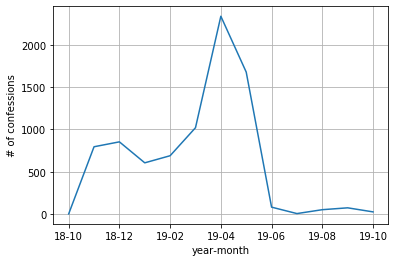

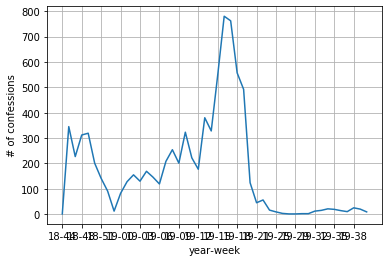

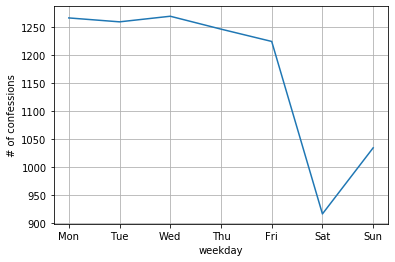

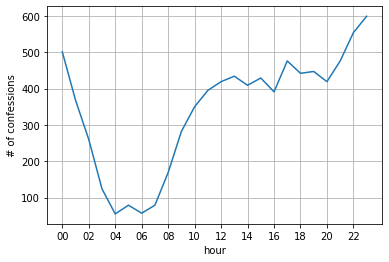

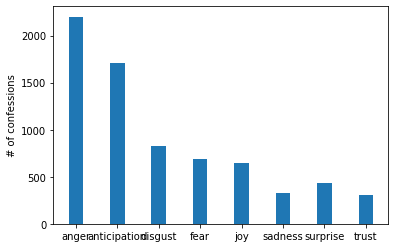

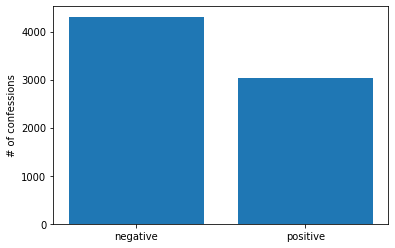

In [135]:
if __name__ == "__main__":
    path='data'
    school_calendar=school_calendar_timestamp()
    word_senti=load_sentiment_dict()
    
    confessions=pre_process(path)
  
    month_plot(confessions)
    week_plot(confessions)
    weekday_plot(confessions)
    hour_plot(confessions)
    sentiment_plot(confessions)
    neg_pos_plot(confessions)
   

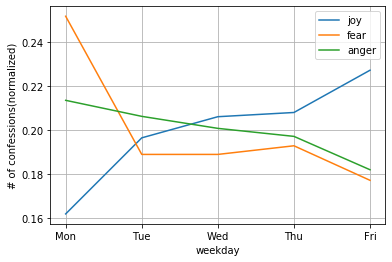

In [133]:
def normalize_series(s):
    total_num=s.sum()
    s=s/total_num
    return s
def weekday_diff_senti_plot(confessions):
    confessions['week_d']=confessions.timestamp.dt.strftime('%a')
    confessions['week_d']=pd.Categorical(confessions['weekday'],categories=['Mon','Tue','Wed','Thu','Fri'],ordered=True)
    #confessions_week=confessions.loc[confessions.weekday!='Sat']
    #confessions_week=confessions_week.loc[confessions.weekday!='Sun']
    joy=confessions.loc[confessions.sentiment=='joy'].groupby('week_d')['content'].count().sort_index()
    fear=confessions.loc[confessions.sentiment=='fear'].groupby('week_d')['content'].count().sort_index()
    anger=confessions.loc[confessions.sentiment=='anger'].groupby('week_d')['content'].count().sort_index()
    joy=normalize_series(joy)
    fear=normalize_series(fear)
    anger=normalize_series(anger)
    p1=plt.plot(list(joy.index),joy.values,label='joy')
    p2=plt.plot(list(fear.index),fear.values,label='fear')
    p3=plt.plot(list(anger.index),anger.values,label='anger')
    plt.xlabel('weekday')
    plt.xticks(['Mon','Tue','Wed','Thu','Fri'])
    plt.ylabel('# of confessions(normalized)')
    plt.grid()
    plt.legend()
    plt.show()
weekday_diff_senti_plot(confessions)

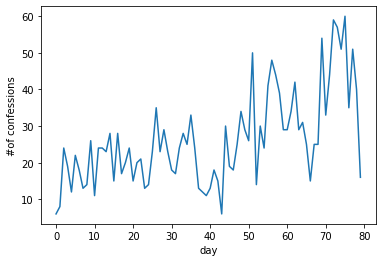

In [134]:
Winter=confessions.loc[confessions.quarter=='Winter']

def plot_day(df):
    day_distri=df.groupby('date')['content'].count()
    plt.plot(range(0,len(day_distri.index)),day_distri.values)
    plt.xlabel('day')
    plt.ylabel('#of confessions')
    plt.show()

plot_day(Winter)